In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset = "/content/mushrooms.txt"
#the file must be in the same directory as notebook.

In [ ]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

y = 2 * y - 3
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def create_batches(X, y, batch_size):
    n = X.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)  # Shuffle indices for randomness
    batches = []

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch_indices = indices[start:end]
        batches.append((X[batch_indices], y[batch_indices]))

    return batches

In [ ]:
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 9.0 MB/s eta 0:00:00


In [ ]:
import ray

ray.init()

def compute_gradient(X_batch, y_batch, w,lambda_reg=0.01):
    predictions = X_batch @ w
    vec = y_batch / (1 + np.exp(y_batch * predictions))
    grad_loss = -np.mean(vec[:, None] * X_batch, axis=0)
    reg_term = lambda_reg * w
    return grad_loss + reg_term

@ray.remote
def compute_gradient_remote(device_data, device_labels, w,lambda_reg=0.01):
    return compute_gradient(device_data, device_labels, w,lambda_reg)

2024-12-18 16:17:57,512	INFO worker.py:1821 -- Started a local Ray instance.


In [ ]:
#ray.shutdown()

In [ ]:
def rand_k_compression(gradient, k):
    indices = np.random.choice(len(gradient), k, replace=False)
    compressed_gradient = np.zeros_like(gradient)
    compressed_gradient[indices] = gradient[indices]
    return compressed_gradient

def top_k_compression(gradient, k):
    indices = np.argsort(np.abs(gradient))[-k:]
    compressed_gradient = np.zeros_like(gradient)
    compressed_gradient[indices] = gradient[indices]
    return compressed_gradient

def perm_k_compression(gradient,k):

      permuted_indices = np.random.permutation(len(gradient))
      compressed_gradient = np.zeros_like(gradient)
      compressed_gradient[permuted_indices[:k]] = gradient[permuted_indices[:k]]
      return compressed_gradient

##MARINA logistic regression

>



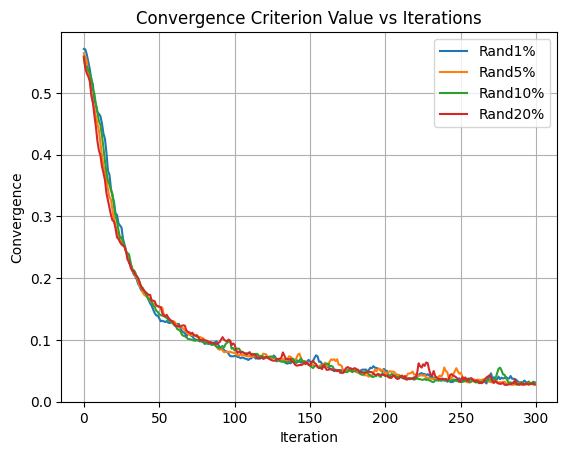

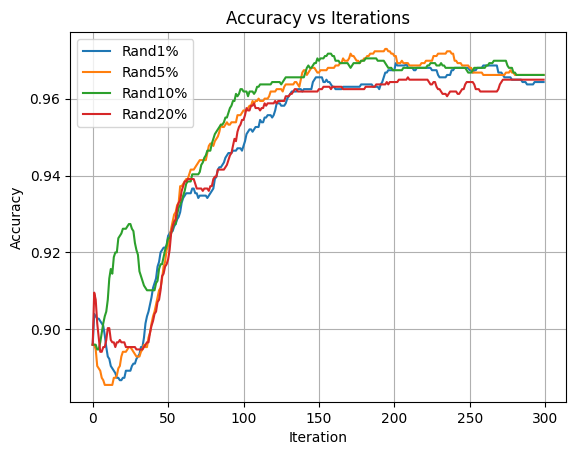

In [ ]:
def marina_logistic(X, y, X_test, y_test, num_devices=10, compression='rand', k=10, num_epochs=300,learning_rate=0.1,p=0.1):
    batches = create_batches(X, y, num_devices)
    w = np.zeros(X.shape[1])
    #L = estimate_lipschitz_constant(batches, num_devices)
    accuracy_arr = []
    convergence_values = []
    ########################################################3
    gradients = []
    futures = [compute_gradient_remote.remote(data[:10], labels[:10], w) for data, labels in batches]
    results = ray.get(futures)
    # for gradient in results:
    #     gradients.append(gradient)

    avg_gradient = np.mean(results, axis=0)
    g_k=avg_gradient
    grad_f_k=results
##################################################################
    for epoch in range(num_epochs):
        w -= learning_rate * g_k
        gradients = []
        futures = [compute_gradient_remote.remote(data[:10], labels[:10], w) for data, labels in batches]
        results = ray.get(futures)

        for i,gradient in enumerate(results):

            #Sample c_k from Bernoulli(p)
            c_k = np.random.binomial(1, p)
            if c_k == 1:
                g_k_plus_1=gradient
            else:

                if compression == 'rand':
                    compressed_gradient = rand_k_compression(gradient-grad_f_k[i], k)

                elif compression == 'top':
                    compressed_gradient = top_k_compression(gradient-grad_f_k[i], k)
                elif compression=='perm':
                    compressed_gradient = perm_k_compression(gradient-grad_f_k[i], k)
                else:
                    raise ValueError("Unknown compression method")

                g_k_plus_1 = g_k + compressed_gradient
            # Average gradient over all devices (if applicable)
            #g_k_plus_1 = np.mean(g_k_plus_1)

            # Update gradient for next iteration
            #g_k = g_k_plus_1


            gradients.append(g_k_plus_1)

        avg_gradient = np.mean(gradients, axis=0)
        #omega = np.mean(np.linalg.norm(gradients - avg_gradient, axis=1)**2)

        #learning_rate = 1.0 / L / (2 * omega / num_devices + 1.0)
        predictions = X_test @ w
        accuracy = np.mean((predictions > 0) == (y_test > 0))
        accuracy_arr.append(accuracy)
        convergence_values.append(np.linalg.norm(avg_gradient))

        g_k=avg_gradient
        grad_f_k = results

    return convergence_values, accuracy_arr

compression_percentages = [0.01, 0.05, 0.1, 0.2]
results_convergence = {}
results_accuracy = {}

for percentage in compression_percentages:
    convergence, accuracy_arr = marina_logistic(X_train[:500], y_train[:500], X_test, y_test,
                                                              compression='rand',
                                                              k=int(percentage * X.shape[1]))

    results_convergence[percentage] = convergence
    results_accuracy[percentage] = accuracy_arr

    plt.plot(convergence, label=f'Rand{percentage*100:.0f}%')
plt.title(f'Convergence Criterion Value vs Iterations')
plt.xlabel('Iteration')
plt.ylabel('Convergence')
plt.legend()
plt.grid()
plt.show()

for percentage in compression_percentages:
    plt.plot(results_accuracy[percentage], label=f'Rand{percentage*100:.0f}%')
plt.title(f'Accuracy vs Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

ray.shutdown()


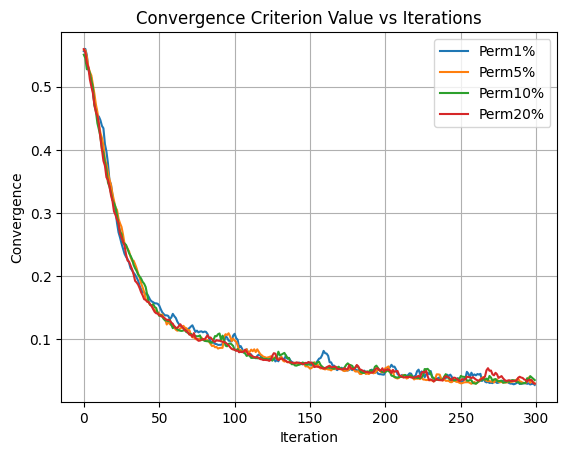

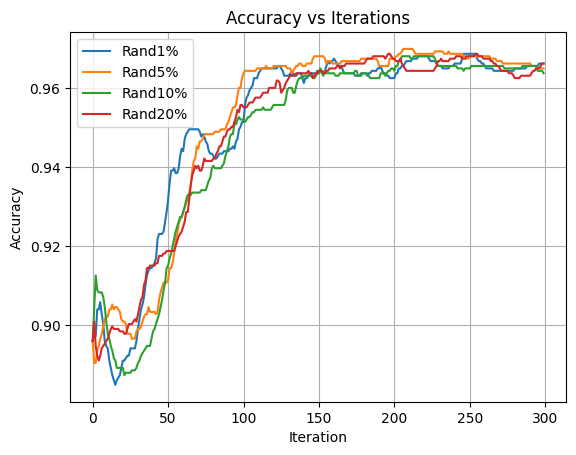

In [ ]:
compression_percentages = [0.01, 0.05, 0.1, 0.2]
results_convergence = {}
results_accuracy = {}

for percentage in compression_percentages:
    convergence, accuracy_arr = marina_logistic(X_train[:500], y_train[:500], X_test, y_test,
                                                              compression='perm',
                                                              k=int(percentage * X.shape[1]))

    results_convergence[percentage] = convergence
    results_accuracy[percentage] = accuracy_arr

    plt.plot(convergence, label=f'Perm{percentage*100:.0f}%')
plt.title(f'Convergence Criterion Value vs Iterations')
plt.xlabel('Iteration')
plt.ylabel('Convergence')
plt.legend()
plt.grid()
plt.show()

for percentage in compression_percentages:
    plt.plot(results_accuracy[percentage], label=f'Perm{percentage*100:.0f}%')
plt.title(f'Accuracy vs Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

ray.shutdown()

In [ ]:
compression_percentages = [0.01, 0.05, 0.1, 0.2]
num_workers_list = [5, 10, 20]
num_epochs = 100
learning_rate = 0.1

results = []

for num_workers in num_workers_list:
    for percentage in compression_percentages:
        convergence, accuracy_arr = marina_logistic(X_train[:500], y_train[:500], X_test, y_test,num_devices=num_workers,
                                                              compression='rand',
                                                              k=int(percentage * X.shape[1]))


        results.append({
            "num_workers": num_workers,
            "compression": percentage,
            "accuracy_arr": accuracy_arr,
            "convergence": convergence
        })

2024-12-18 16:40:13,504	INFO worker.py:1821 -- Started a local Ray instance.
(compute_gradient_remo pid=7183) te


(compute_gradient pid=7184) _remote
(compute_gradient_remote pid=7184) :task
(compute_gradient_remote pid=7184) _name:compute_gradient_remote


(compute_gradient_remote pid=7184) :task_nam
(compute_gradient_remote pid=7184) e:compute_gradient_remote


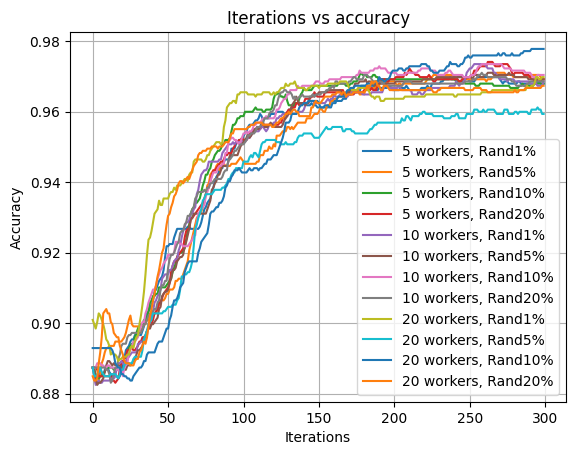

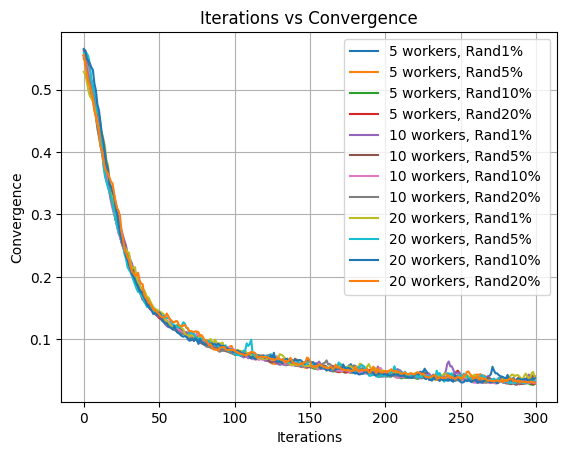

In [ ]:
for result in results:
    plt.plot(result["accuracy_arr"], label=f"{result['num_workers']} workers, Rand{result['compression']*100:.0f}%")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Iterations vs accuracy")
plt.legend()
plt.grid()
plt.show()

for result in results:
    plt.plot(result["convergence"], label=f"{result['num_workers']} workers, Rand{result['compression']*100:.0f}% ")
plt.xlabel("Iterations")
plt.ylabel("Convergence")
plt.title("Iterations vs Convergence")
plt.legend()
plt.grid()
plt.show()

2024-12-18 18:14:27,979	INFO worker.py:1821 -- Started a local Ray instance.


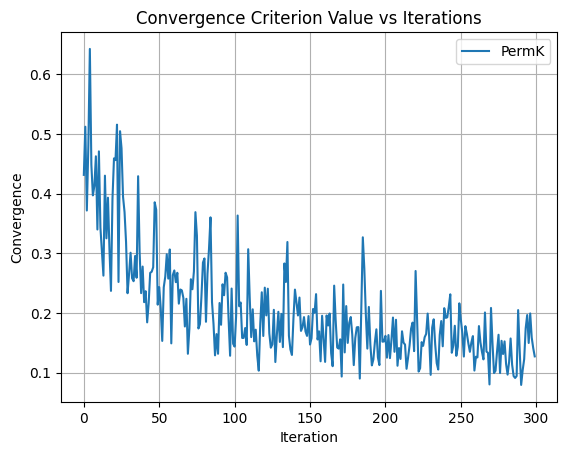

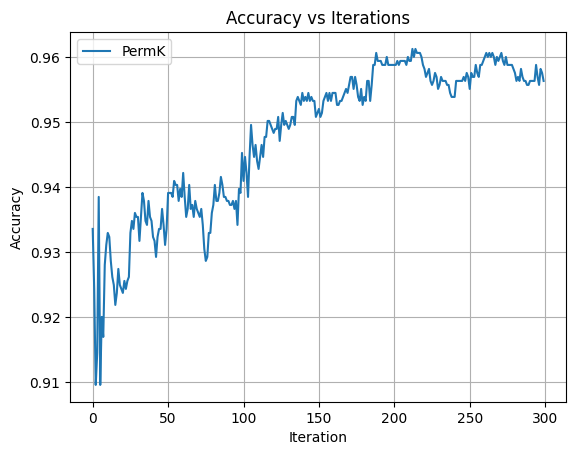

In [ ]:
import numpy as np
import ray
import matplotlib.pyplot as plt

@ray.remote
def compute_gradient_remote(data, labels, w):
    # Вычисление градиента
    predictions = data @ w
    errors = predictions - labels
    gradient = data.T @ errors / len(labels)
    return gradient

def create_batches(X, y, num_devices):
    batch_size = len(X) // num_devices
    return [(X[i * batch_size:(i + 1) * batch_size], y[i * batch_size:(i + 1) * batch_size]) for i in range(num_devices)]

def perm_k_compressor_large_d(x):
    d = len(x)
    n = int(np.sqrt(d))  # Предполагаем, что d делится на n
    q = d // n

    permuted_indices = np.random.permutation(d)
    compressed_vector = np.zeros(n)

    for i in range(n):
        for j in range(q):
            compressed_vector[i] += x[permuted_indices[q * i + j]]

    return compressed_vector

def perm_k_compressor_small_d(x):
    d = len(x)
    n = int(np.ceil(1.5 * d))  # Предполагаем, что n делится на d
    k = n // d

    permuted_indices = np.random.permutation(d)
    compressed_vector = np.zeros(k)

    for i in range(k):
        compressed_vector[i] = x[permuted_indices[i % d]]

    return compressed_vector

def marina_logistic(X, y, X_test, y_test, num_devices=10, num_epochs=300, learning_rate=0.1, p=0.1):
    batches = create_batches(X, y, num_devices)
    w = np.zeros(X.shape[1])

    accuracy_arr = []
    convergence_values = []

    # Инициализация градиентов
    futures = [compute_gradient_remote.remote(data[:10], labels[:10], w) for data, labels in batches]
    results = ray.get(futures)

    avg_gradient = np.mean(results, axis=0)
    g_k = avg_gradient

    for epoch in range(num_epochs):
        w -= learning_rate * g_k

        gradients = []
        futures = [compute_gradient_remote.remote(data[:10], labels[:10], w) for data, labels in batches]
        results = ray.get(futures)

        for i, gradient in enumerate(results):
            c_k = np.random.binomial(1, p)
            if c_k == 1:
                g_k_plus_1 = gradient
            else:
                # Проверяем размерность градиента и применяем соответствующий компрессор
                if len(gradient) >= len(w):  # d >= n case
                    compressed_gradient = perm_k_compressor_large_d(gradient)
                    # Увеличиваем размерность до len(w)
                    g_k_plus_1 = np.zeros_like(w)
                    g_k_plus_1[:len(compressed_gradient)] += compressed_gradient
                else:  # d < n case
                    compressed_gradient = perm_k_compressor_small_d(gradient)
                    # Увеличиваем размерность до len(w)
                    g_k_plus_1 = np.zeros_like(w)
                    g_k_plus_1[:len(compressed_gradient)] += compressed_gradient

            gradients.append(g_k_plus_1)

        avg_gradient = np.mean(gradients, axis=0)

        predictions = X_test @ w
        accuracy = np.mean((predictions > 0) == (y_test > 0))
        accuracy_arr.append(accuracy)
        convergence_values.append(np.linalg.norm(avg_gradient))

        g_k = avg_gradient

    return convergence_values, accuracy_arr

compression_percentages = [0.01, 0.05, 0.1, 0.2]
results_convergence = {}
results_accuracy = {}


convergence, accuracy_arr = marina_logistic(X_train[:500], y_train[:500], X_test, y_test,
                                            num_epochs=300,
                                            learning_rate=0.1,
                                            p=0.1)

results_convergence[percentage] = convergence
results_accuracy[percentage] = accuracy_arr

# Построение графиков значений сходимости
#for percentage in compression_percentages:
plt.plot(convergence, label=f'PermK')
plt.title(f'Convergence Criterion Value vs Iterations')
plt.xlabel('Iteration')
plt.ylabel('Convergence')
plt.legend()
plt.grid()
plt.show()

# Построение графиков точности
#for percentage in compression_percentages:
plt.plot(accuracy_arr, label=f'PermK')
plt.title(f'Accuracy vs Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

ray.shutdown()


In [ ]:

# def marina_logistic_return_grad(X, y, X_test, y_test, num_devices=10, compression='rand', k=10, num_epochs=300,learning_rate=0.1,p=0.1):
#     batches = create_batches(X, y, num_devices)
#     w = np.zeros(X.shape[1])
#     ########################################################3
#     gradient
#     #futures = [compute_gradient(data[:10], labels[:10], w) for data, labels in batches]
#     #results = ray.get(futures)
#     # for gradient in results:
#     #     gradients.append(gradient)

#     #avg_gradient = np.mean(results, axis=0)
#     g_k=avg_gradient
#     grad_f_k=results
# ##################################################################
#     for epoch in range(1,num_epochs):
#         #w -= learning_rate * g_k
#         gradients = []
#         futures = [compute_gradient_remote.remote(data[:10], labels[:10], w) for data, labels in batches]
#         results = ray.get(futures)

#         for i,gradient in enumerate(results):

#             #Sample c_k from Bernoulli(p)
#             c_k = np.random.binomial(1, p)
#             if c_k == 1:
#                 g_k_plus_1=gradient
#             else:

#                 if compression == 'rand':
#                     compressed_gradient = rand_k_compression(gradient-grad_f_k[i], k)

#                 elif compression == 'top':
#                     compressed_gradient = top_k_compression(gradient-grad_f_k[i], k)
#                 elif compression=='perm':
#                     compressed_gradient = perm_k_compression(gradient-grad_f_k[i], k)
#                 else:
#                     raise ValueError("Unknown compression method")

#                 g_k_plus_1 = g_k + compressed_gradient
#             # Average gradient over all devices (if applicable)
#             #g_k_plus_1 = np.mean(g_k_plus_1)

#             # Update gradient for next iteration
#             #g_k = g_k_plus_1


#             gradients.append(g_k_plus_1)

#         avg_gradient = np.mean(gradients, axis=0)
#         #omega = np.mean(np.linalg.norm(gradients - avg_gradient, axis=1)**2)

#         #learning_rate = 1.0 / L / (2 * omega / num_devices + 1.0)
#         predictions = X_test @ w
#         accuracy = np.mean((predictions > 0) == (y_test > 0))
#         accuracy_arr.append(accuracy)
#         convergence_values.append(np.linalg.norm(avg_gradient))

#         g_k=avg_gradient
#         grad_f_k = results

#     return g_k

# @ray.remote
# def compute_gradient_remote(device_data, device_labels, w,lambda_reg=0.01):
#     return compute_gradient(device_data, device_labels, w,lambda_reg)

# def marina_logistic_with_local_updates(X, y, X_test, y_test, num_devices=10, compression='rand', k=10, local_iter_num=10,num_epochs=300,learning_rate=0.1,p=0.1):
#     batches = create_batches(X, y, num_devices)
#     w = np.zeros(X.shape[1])
#     #L = estimate_lipschitz_constant(batches, num_devices)
#     accuracy_arr = []
#     convergence_values = []
#     ########################################################3
#     gradients = []
#     futures = [compute_gradient_remote.remote(data[:10], labels[:10], w) for data, labels in batches]
#     results = ray.get(futures)
#     # for gradient in results:
#     #     gradients.append(gradient)

#     avg_gradient = np.mean(results, axis=0)
#     g_k=avg_gradient
#     grad_f_k=results
# ##################################################################
#     for epoch in range(num_epochs/local_iter_num):
#         w -= learning_rate * g_k
#         gradients = []
#         futures = [compute_gradient_remote.remote(data, labels, w) for data, labels in batches]
#         results = ray.get(futures)

#         for i,gradient in enumerate(results):

#             #Sample c_k from Bernoulli(p)
#             c_k = np.random.binomial(1, p)
#             if c_k == 1:
#                 g_k_plus_1=gradient
#             else:

#                 if compression == 'rand':
#                     compressed_gradient = rand_k_compression(gradient-grad_f_k[i], k)

#                 elif compression == 'top':
#                     compressed_gradient = top_k_compression(gradient-grad_f_k[i], k)
#                 elif compression=='perm':
#                     compressed_gradient = perm_k_compression(gradient-grad_f_k[i], k)
#                 else:
#                     raise ValueError("Unknown compression method")

#                 g_k_plus_1 = g_k + compressed_gradient
#             # Average gradient over all devices (if applicable)
#             #g_k_plus_1 = np.mean(g_k_plus_1)

#             # Update gradient for next iteration
#             #g_k = g_k_plus_1


#             gradients.append(g_k_plus_1)

#         avg_gradient = np.mean(gradients, axis=0)
#         #omega = np.mean(np.linalg.norm(gradients - avg_gradient, axis=1)**2)

#         #learning_rate = 1.0 / L / (2 * omega / num_devices + 1.0)
#         predictions = X_test @ w
#         accuracy = np.mean((predictions > 0) == (y_test > 0))
#         accuracy_arr.append(accuracy)
#         convergence_values.append(np.linalg.norm(avg_gradient))

#         g_k=avg_gradient
#         grad_f_k = results

#     return convergence_values, accuracy_arr

# compression_percentages = [0.01, 0.05, 0.1, 0.2]
# results_convergence = {}
# results_accuracy = {}

# for percentage in compression_percentages:
#     convergence, accuracy_arr = marina_logistic(X_train[:500], y_train[:500], X_test, y_test,
#                                                               compression='rand',
#                                                               k=int(percentage * X.shape[1]))

#     results_convergence[percentage] = convergence
#     results_accuracy[percentage] = accuracy_arr

#     plt.plot(convergence, label=f'Rand{percentage*100:.0f}%')
# plt.title(f'Convergence Criterion Value vs Iterations')
# plt.xlabel('Iteration')
# plt.ylabel('Convergence')
# plt.legend()
# plt.grid()
# plt.show()

# for percentage in compression_percentages:
#     plt.plot(results_accuracy[percentage], label=f'Rand{percentage*100:.0f}%')
# plt.title(f'Accuracy vs Iterations')
# plt.xlabel('Iteration')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid()
# plt.show()

# ray.shutdown()


(6499, 112)

##let's look on linreg

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import  mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Load the dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target

#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler() #feature scaling
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
# X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]

In [ ]:
def linear_gradient(X_batch, y_batch, w, lambda_reg=0.01):
    predictions = X_batch @ w
    error = predictions - y_batch
    grad_loss = 2 * np.mean(error[:, None] * X_batch, axis=0)
    reg_term = lambda_reg * w
    return grad_loss +reg_term

@ray.remote
def linear_gradient_remote(device_data, device_labels, w, lambda_reg=0.01):
    return linear_gradient(device_data, device_labels, w, lambda_reg)

In [ ]:
from sklearn.metrics import  mean_squared_error
def marina_regression(X, y, X_test, y_test, gradient_func, compute_gradient_remote_func,
                      num_devices=10, compression='rand', k=10, num_epochs=300, learning_rate=0.1, p=0.1):
    batches = create_batches(X, y, num_devices)
    w = np.zeros(X.shape[1])
    accuracy_arr = []
    convergence_values = []

    # initial gradients
    futures = [compute_gradient_remote_func.remote(data, labels, w) for data, labels in batches]
    results = ray.get(futures)
    avg_gradient = np.mean(results, axis=0)
    g_k = avg_gradient
    grad_f_k = results

    for epoch in range(num_epochs):
        w -= learning_rate * g_k
        gradients = []
        futures = [compute_gradient_remote_func.remote(data[:30], labels[:30], w) for data, labels in batches]
        results = ray.get(futures)

        for i, gradient in enumerate(results):
            c_k = np.random.binomial(1, p)
            if c_k == 1:
                g_k_plus_1 = gradient
            else:
                if compression == 'rand':
                    compressed_gradient = rand_k_compression(gradient - grad_f_k[i], k)
                elif compression == 'top':
                    compressed_gradient = top_k_compression(gradient - grad_f_k[i], k)
                else:
                    raise ValueError("Unknown compression method")
                g_k_plus_1 = g_k + compressed_gradient

            gradients.append(g_k_plus_1)

        avg_gradient = np.mean(gradients, axis=0)
        predictions = X_test @ w
        mse = mean_squared_error(y_test, predictions)
        accuracy_arr.append(mse)
        convergence_values.append(np.linalg.norm(avg_gradient))

        g_k = avg_gradient
        grad_f_k = results

    return convergence_values, accuracy_arr

In [ ]:
compression_percentages = [0.01, 0.05, 0.1, 0.2]
results_convergence_linreg = {}
results_accuracy_linreg = {}

# linreg
for percentage in compression_percentages:
    convergence, accuracy_arr = marina_regression(
        X_train[:1000], y_train[:1000], X_test, y_test,
        gradient_func=linear_gradient,
        compute_gradient_remote_func=linear_gradient_remote,
        compression='rand',
        k=int(percentage * X.shape[1])
    )
    results_convergence_linreg[percentage] = convergence
    results_accuracy_linreg[percentage] = accuracy_arr

(linear_gradient_remote pid=24562) 


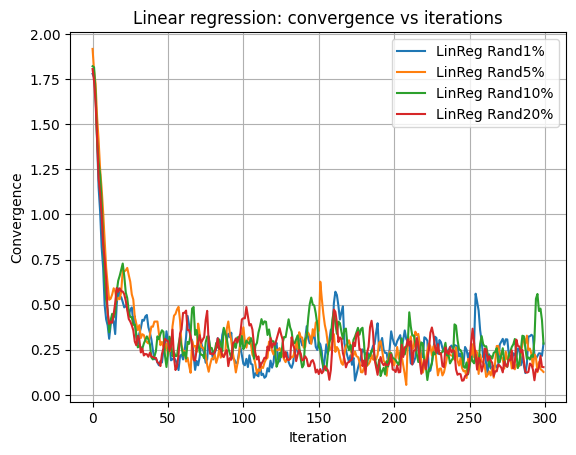

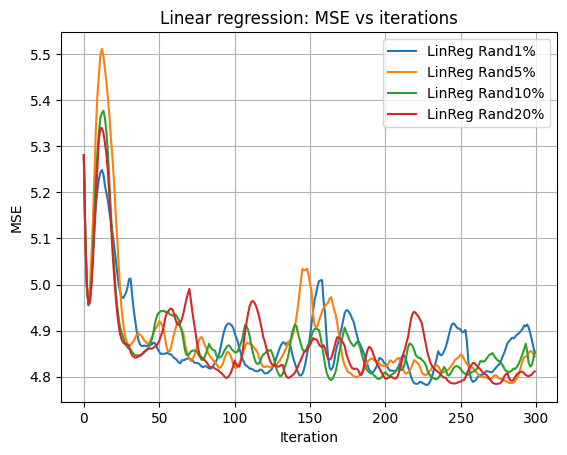

In [ ]:
# linreg convergence
for percentage in compression_percentages:
    plt.plot(results_convergence_linreg[percentage], label=f'LinReg Rand{percentage*100:.0f}%')
plt.title('Linear regression: convergence vs iterations')
plt.xlabel('Iteration')
plt.ylabel('Convergence')
plt.legend()
plt.grid()
plt.show()

# linreg accuracy
for percentage in compression_percentages:
    plt.plot(results_accuracy_linreg[percentage], label=f'LinReg Rand{percentage*100:.0f}%')
plt.title('Linear regression: MSE vs iterations')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

 "Try to play with different numbers of workers n, datasets, and different levels of compression"

In [ ]:
# adjust MARINA function to track communication costs (bits sent)

def marina_regression(X, y, X_test, y_test, gradient_func, compute_gradient_remote_func,
                      num_workers=10, compression='rand', k=10, num_epochs=300,
                      learning_rate=0.1, p=0.1):
    ray.init(ignore_reinit_error=True)

    batch_size = len(X) // num_workers
    batches = [(X[i * batch_size:(i + 1) * batch_size], y[i * batch_size:(i + 1) * batch_size])
               for i in range(num_workers)]

    w = np.zeros(X.shape[1])
    g_k = np.zeros_like(w)
    total_sent_bits = 0
    iterations = []

    accuracy_arr = []
    log_loss_arr = []

    for epoch in range(num_epochs):
        futures = [compute_gradient_remote_func.remote(batch[0], batch[1], w) for batch in batches]
        local_gradients = ray.get(futures)

        compressed_gradients = []
        for gradient in local_gradients:
            c_k = np.random.binomial(1, p)
            if c_k == 1:
                g_k_plus_1 = gradient
                bits_sent = gradient.size * 32  # Assume 32-bit floats
            else:
                if compression == 'rand':
                    compressed_gradient = rand_k_compression(gradient - g_k, k)
                elif compression == 'top':
                    compressed_gradient = top_k_compression(gradient - g_k, k)
                else:
                    raise ValueError("Unknown compression method")

                g_k_plus_1 = g_k + compressed_gradient
                bits_sent = k * 32

            compressed_gradients.append(g_k_plus_1)
            total_sent_bits += bits_sent

        g_k = np.mean(compressed_gradients, axis=0)
        w -= learning_rate * g_k

        predictions = X_test @ w
        if gradient_func == compute_gradient:
            accuracy = np.mean((predictions > 0) == (y_test > 0))
            loss = np.mean(np.log(1 + np.exp(-y_test * predictions)))
        else:
            accuracy = None
            loss = np.mean((predictions - y_test) ** 2)

        accuracy_arr.append(accuracy)
        log_loss_arr.append(loss)
        iterations.append(epoch)

    ray.shutdown()
    return iterations, total_sent_bits, accuracy_arr, log_loss_arr

In [ ]:
compression_percentages = [0.01, 0.05, 0.1, 0.2]
num_workers_list = [5, 10, 20]
num_epochs = 100
learning_rate = 0.1

results = []

for num_workers in num_workers_list:
    for compression in compression_percentages:
        iterations, sent_bits, accuracy_arr, log_loss_arr = marina_regression(
            X_train, y_train, X_test, y_test, gradient_func=compute_gradient,
            compute_gradient_remote_func=compute_gradient_remote, num_workers=num_workers,
            compression='rand', k=int(compression * X_train.shape[1]),
            num_epochs=num_epochs, learning_rate=learning_rate, p=0.1
        )

        results.append({
            "num_workers": num_workers,
            "compression": compression,
            "iterations": iterations,
            "sent_bits": sent_bits,
            "accuracy_arr": accuracy_arr,
            "log_loss_arr": log_loss_arr
        })

2024-12-18 11:29:15,047	INFO worker.py:1654 -- Calling ray.init() again after it has already been called.
2024-12-18 11:29:27,871	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-18 11:29:44,045	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-18 11:29:57,887	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-18 11:30:15,123	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-18 11:30:35,867	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-18 11:30:56,018	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-18 11:31:17,501	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-18 11:31:38,034	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-18 11:32:07,057	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-18 11:32:36,252	INFO worker.py:1821 -- Started a local Ray instance.
2024-12-18 11:33:03,562	INFO worker.py:1821 -- Started a local Ray instance.


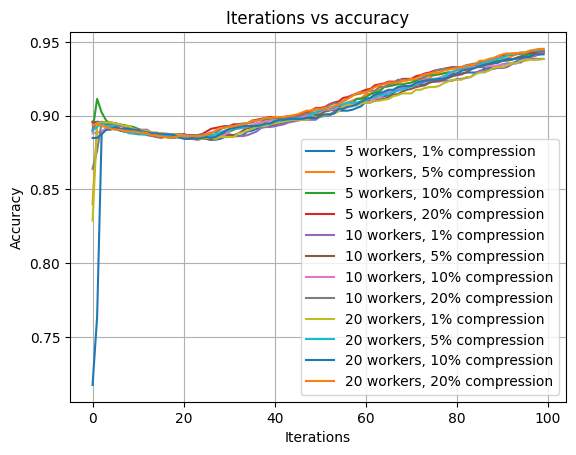

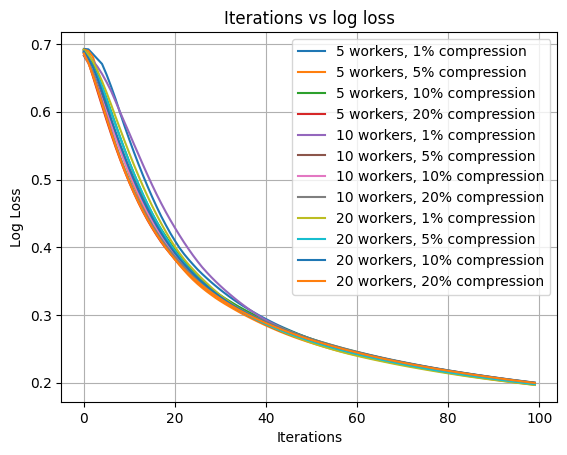

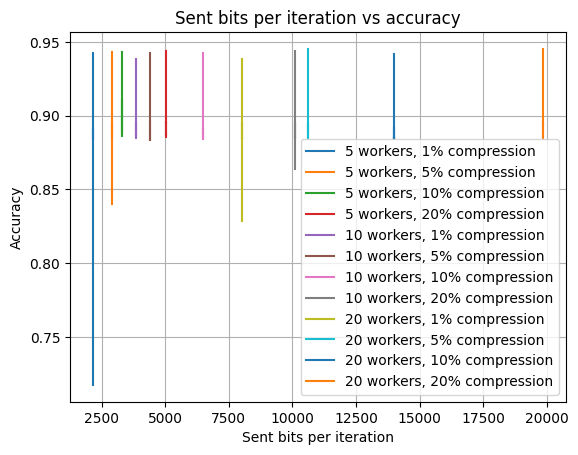

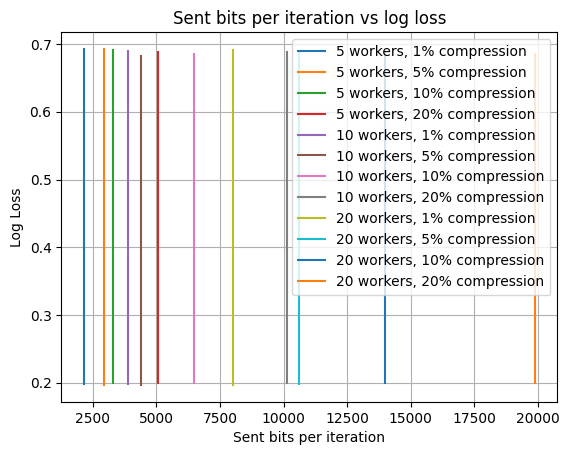

In [ ]:
for result in results:
    plt.plot(result["iterations"], result["accuracy_arr"], label=f"{result['num_workers']} workers, {result['compression']*100:.0f}% compression")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Iterations vs accuracy")
plt.legend()
plt.grid()
plt.show()

for result in results:
    plt.plot(result["iterations"], result["log_loss_arr"], label=f"{result['num_workers']} workers, {result['compression']*100:.0f}% compression")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Iterations vs log loss")
plt.legend()
plt.grid()
plt.show()

for result in results:
    num_iterations = len(result["iterations"])
    result["sent_bits_per_iteration"] = [result["sent_bits"] / num_iterations] * num_iterations

for result in results:
    plt.plot(result["sent_bits_per_iteration"], result["accuracy_arr"], label=f"{result['num_workers']} workers, {result['compression']*100:.0f}% compression")
plt.xlabel("Sent bits per iteration")
plt.ylabel("Accuracy")
plt.title("Sent bits per iteration vs accuracy")
plt.legend()
plt.grid()
plt.show()

for result in results:
    plt.plot(result["sent_bits_per_iteration"], result["log_loss_arr"], label=f"{result['num_workers']} workers, {result['compression']*100:.0f}% compression")
plt.xlabel("Sent bits per iteration")
plt.ylabel("Log Loss")
plt.title("Sent bits per iteration vs log loss")
plt.legend()
plt.grid()
plt.show()

# **Iterations -- accuracy**

1) all converge to a similar accuracy (~95%) after around 100 iterations, regardless of the number of workers or compression level

2) initial fluctuations (~10 iter.) are stronger for fewer n of workers or higher compression

So, when increasing compression it slightly delays convergence initially but has minimal impact on the final accuracy.But increasing the number of workers smoothens convergence

# **Iteraions -- log loss**

1) log loss decreases across all settings with all curves converging to the same final value (~0.2)

2) higher compression causes slightly slower convergence

So, log loss reduction is robust to compression and worker count (as long as the total number of iterations is sufficient)

#  **Sent bits per iteration -- accuracy**

1) number of sent bits decreases significantly as compression increases

2) accuracy remains high (~95%) even at low compression levels

3) fewer bits sent correlates with slightly noisier but overall stable accuracy

So, higher compression greatly reduces communication costs (without loss in accuracy)

# **Sent bits per iteration -- log loss**

1) log loss decreases to the same value (~0.2) even when the number of sent bits is reduced through compression

2) higher compression (1%) achieves comparable results to lower compression (20%) with far fewer bits

3) there is a strong correlation between sent bits and log loss performance, showing declining returns for higher communication costs

So, compression effectively reduces communication overhead while maintaining log loss performance